# classification es el notebook oficial de clasificación

### - Limpiamos los datos según conclusiones del notebook main
### - Probaremos distintos algorítmos de clasificación y compararemos los resultados
### - Utilizamos el dataset de train ya recortado por la cátedra (igual creamos un test para pruebas internas)

## A probar: PERCEPTRON - LOGISTIC REGRESSION - SVM -

---





## ACA TODOS LOS IMPORTS DEL NOTEBOOK

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_auc_score, roc_curve, RocCurveDisplay, PrecisionRecallDisplay, plot_precision_recall_curve, plot_roc_curve

## LECTURA Y LIMPIEZA DEL DATASET

In [2]:
df_orig = pd.read_csv(r"DS_G3_HeartFailure_FULL_train.csv",index_col=0)

In [3]:
df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking","creatinine_phosphokinase","platelets"],axis=1)
# NOS QUEDAMOS CON AGE, EJECTION_FRACTION, SERUM_CREATININE, SERUM_SODIUM Y DEATH_EVENT

In [4]:
feat_train, feat_test, targ_train, targ_test = train_test_split(df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"],test_size=0.2)
#HAY QUE SEPARAR EL TEST ANTES DE ESTANDARIZAR PARA QUE NO INFLUYAN LOS FEATURES DE TEST EN LA MEDIA Y VARIANZA

In [5]:
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)

In [6]:
scaler.var_ # ESTA VARIANZA HAY Q USAR PARA STANDARIZAR EL TARG_TEST

array([134.52076423, 142.42038321,   1.44057696,  20.85830981])

In [7]:
scaler.mean_ # ESTA MEDIA HAY Q USAR PARA STANDARIZAR EL TARG_TEST

array([ 59.88481675,  37.72251309,   1.48298429, 136.2513089 ])

## ACA TENEMOS EL DATASET RECORTADO Y STANDARIZADO 

# LOGISTIC REGRESSION

In [17]:
hyperparam = {"poly__degree":[n for n in range(1,7)],"regressor__C":[n for n in np.logspace(-10.0,4.0, num=25)]}

lr_model = Pipeline([["poly",PolynomialFeatures(degree=1,include_bias=True)],["regressor",LogisticRegression(fit_intercept=False, C=1.0, tol=0.000001, penalty="l2",max_iter=10000)]])

lr_grilla = GridSearchCV(lr_model,hyperparam,cv=50,scoring="recall",n_jobs=-1)

lr_grilla.fit(feat_train,targ_train)

GridSearchCV(cv=50,
             estimator=Pipeline(steps=[['poly', PolynomialFeatures(degree=1)],
                                       ['regressor',
                                        LogisticRegression(fit_intercept=False,
                                                           max_iter=10000,
                                                           tol=1e-06)]]),
             n_jobs=-1,
             param_grid={'poly__degree': [1, 2, 3, 4, 5, 6],
                         'regressor__C': [1e-10, 3.831186849557293e-10,
                                          1.4677992676220676e-09,
                                          5.623413251903491e-09,
                                          2.1544346900318866e-08,
                                          8.25404185268019e-08,
                                          3....
                                          1.21152765862859e-06,
                                          4.641588833612782e-06,
                        

In [18]:
lr_model = lr_grilla.best_estimator_

In [40]:
lr_model.predict_proba(feat_train)

array([[0.50001225, 0.49998775],
       [0.50000678, 0.49999322],
       [0.50003773, 0.49996227],
       [0.50145939, 0.49854061],
       [0.50000272, 0.49999728],
       [0.50001571, 0.49998429],
       [0.49975379, 0.50024621],
       [0.49994645, 0.50005355],
       [0.50003119, 0.49996881],
       [0.50055869, 0.49944131],
       [0.50007659, 0.49992341],
       [0.49987459, 0.50012541],
       [0.50000102, 0.49999898],
       [0.49966187, 0.50033813],
       [0.49993335, 0.50006665],
       [0.49977464, 0.50022536],
       [0.50119774, 0.49880226],
       [0.49990362, 0.50009638],
       [0.50047395, 0.49952605],
       [0.31947057, 0.68052943],
       [0.50000503, 0.49999497],
       [0.50002129, 0.49997871],
       [0.50000423, 0.49999577],
       [0.499985  , 0.500015  ],
       [0.50003313, 0.49996687],
       [0.49993684, 0.50006316],
       [0.49990519, 0.50009481],
       [0.49990461, 0.50009539],
       [0.51493235, 0.48506765],
       [0.44025237, 0.55974763],
       [0.

In [25]:
print(lr_grilla.best_params_)
print("Grilla Best Score: {}".format(lr_grilla.best_score_))


print("Cross Validation Score: {}".format(cross_val_score(lr_model, feat_train, targ_train,cv=50,scoring="recall").mean()))

{'poly__degree': 5, 'regressor__C': 3.162277660168379e-07}
Grilla Best Score: 0.75
Cross Validation Score: 0.75


In [28]:
lr_predicted = cross_val_predict(lr_model,feat_train,targ_train,cv=50,method="predict")

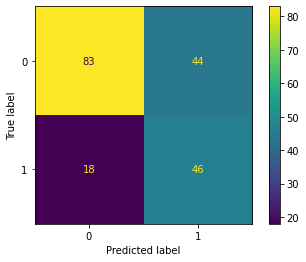

In [41]:
cm = confusion_matrix(targ_train, lr_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

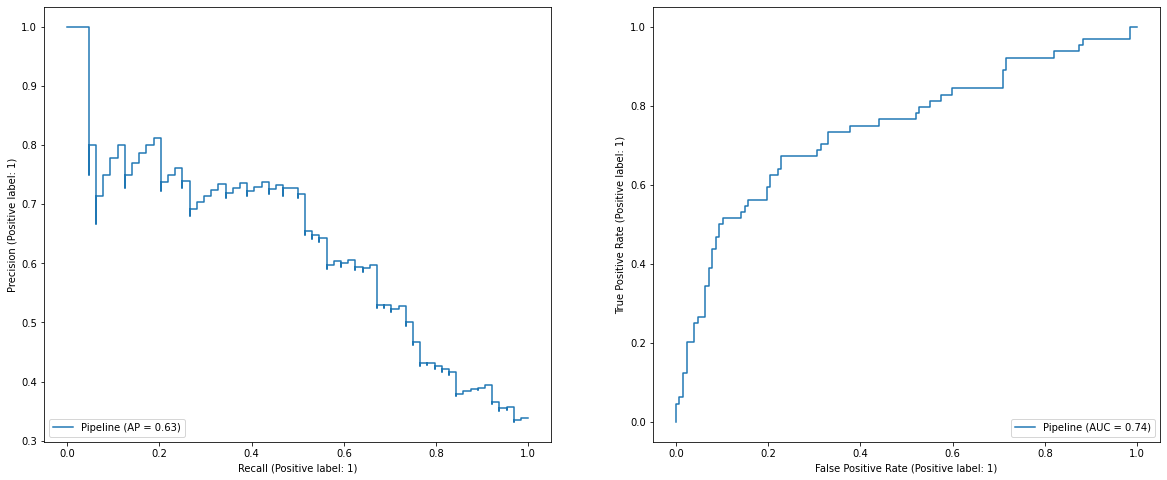

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(lr_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(lr_model, feat_train, targ_train,ax=ax2)

---

# SUPPORT VECTOR MACHINES

In [95]:
hyperparam = {"poly__degree":[n for n in range(1,7)],"SVC__C":[n for n in np.logspace(-8.0,-3.0, num=25)]}

svml_model = Pipeline([["poly",PolynomialFeatures(degree=1,include_bias=True)],["SVC",LinearSVC(loss='hinge', C=1.0, fit_intercept=False, penalty='l2', max_iter=5000)]])

grilla = GridSearchCV(svml_model,hyperparam,cv=50,scoring="recall",n_jobs=-1)

grilla.fit(feat_train,targ_train)

GridSearchCV(cv=50,
             estimator=Pipeline(steps=[['poly', PolynomialFeatures(degree=1)],
                                       ['SVC',
                                        LinearSVC(fit_intercept=False,
                                                  loss='hinge',
                                                  max_iter=5000)]]),
             n_jobs=-1,
             param_grid={'SVC__C': [1e-08, 1.6155980984398728e-08,
                                    2.6101572156825384e-08,
                                    4.2169650342858225e-08,
                                    6.812920690579608e-08,
                                    1.1006941712522103e-07,
                                    1.7782794100389227e-07,
                                    2.8729848333536685e-07,
                                    4...
                                    7.498942093324558e-07, 1.21152765862859e-06,
                                    1.9573417814876616e-06,
                  

In [96]:
svml_model = grilla.best_estimator_
print(grilla.best_params_)
print(grilla.best_score_)
print(accuracy_score(targ_train, svml_model.predict(feat_train)))

{'SVC__C': 4.641588833612782e-07, 'poly__degree': 5}
0.75
0.7015706806282722


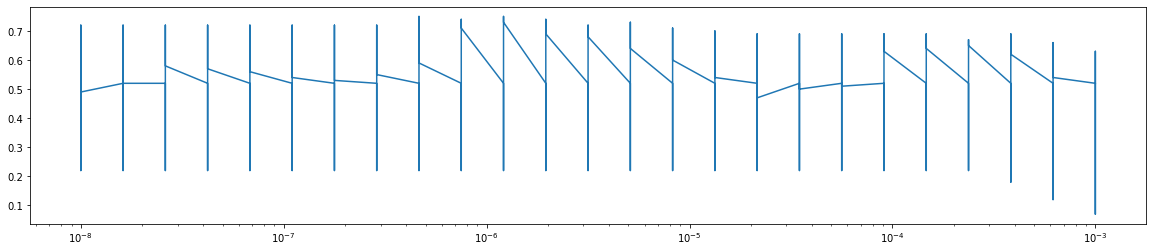

In [98]:
grilla.cv_results_["mean_test_score"]
fig, ax1 = plt.subplots(1, 1, figsize=(20, 4))
plt.plot(grilla.cv_results_["param_SVC__C"],grilla.cv_results_["mean_test_score"],scaley="log")
ax1.set_xscale('log')

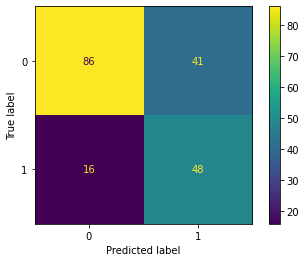

In [99]:
cm = confusion_matrix(targ_train, svml_model.predict(feat_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

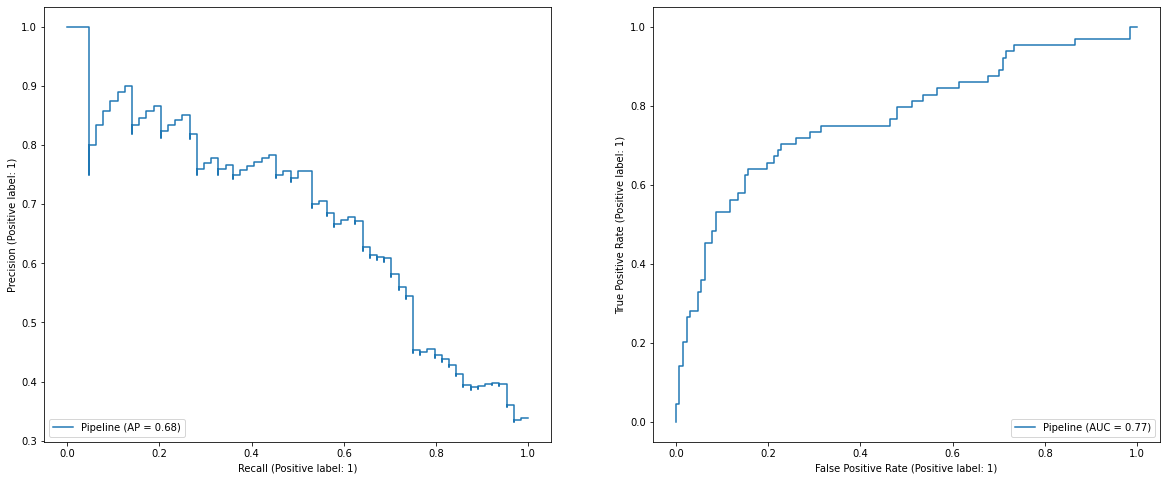

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(svml_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(svml_model, feat_train, targ_train,ax=ax2)

In [93]:
hyperparam = {"poly__degree":[n for n in range(1,5)],"SVC__C":[n for n in np.logspace(-8.0,-4.0, num=25)]}#,"SVC__gamma":[n for n in np.logspace(5.0,10.0, num=5)]}

svm_model = Pipeline([["poly",PolynomialFeatures(degree=1,include_bias=True)],["SVC",SVC(kernel='rbf', C=1.0, gamma=0.01)]])

grilla = GridSearchCV(svm_model,hyperparam,cv=50,scoring="recall",n_jobs=-1)

grilla.fit(feat_train,targ_train)

GridSearchCV(cv=50,
             estimator=Pipeline(steps=[['poly', PolynomialFeatures(degree=1)],
                                       ['SVC', SVC(gamma=0.01)]]),
             n_jobs=-1,
             param_grid={'SVC__C': [1e-08, 1.4677992676220705e-08,
                                    2.1544346900318822e-08,
                                    3.162277660168379e-08,
                                    4.641588833612782e-08,
                                    6.812920690579608e-08, 1e-07,
                                    1.4677992676220674e-07,
                                    2.1544346900318822e-07,
                                    3.162277660168379e-07,
                                    4.6415888336127725e-07,
                                    6.812920690579608e-07, 1e-06,
                                    1.4677992676220675e-06,
                                    2.1544346900318822e-06,
                                    3.162277660168379e-06,
               

In [94]:
svm_model = grilla.best_estimator_
print(grilla.best_params_)
print(grilla.best_score_)
print(accuracy_score(targ_train, svm_model.predict(feat_train)))

{'SVC__C': 1e-08, 'poly__degree': 1}
0.0
0.6649214659685864


In [85]:
grilla.cv_results_["mean_test_score"]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

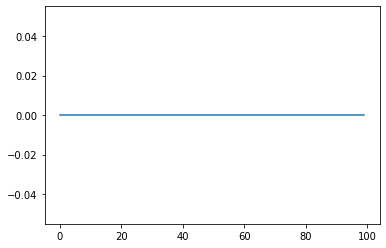

In [10]:
plt.plot([n for n in range(len(grilla.cv_results_["mean_test_score"]))],grilla.cv_results_["mean_test_score"])

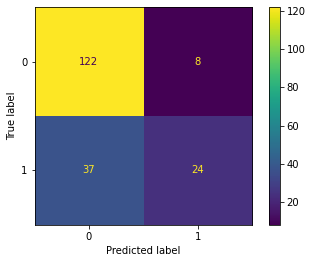

In [37]:
cm = confusion_matrix(targ_train, svm_model.predict(feat_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

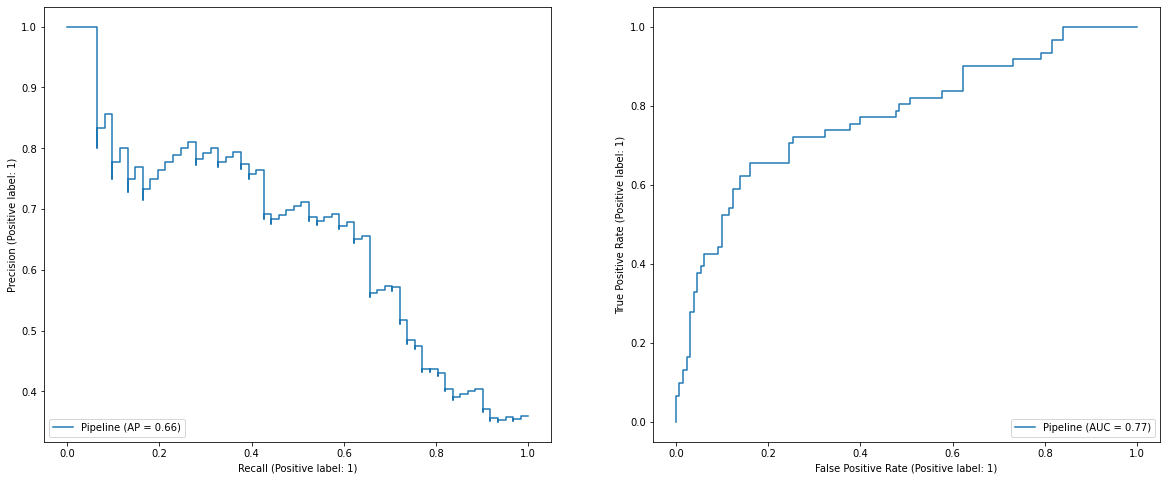

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(svm_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(svm_model, feat_train, targ_train,ax=ax2)